In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import importlib
import helper_functions.flood_utils
importlib.reload(helper_functions.flood_utils)
from helper_functions import flood_utils
from osgeo import gdal, ogr

import LTA_API_key
importlib.reload(LTA_API_key)
import LTA_API_key as apiKeys

# Flooding hot spots

In [71]:
flooding_hotspots = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\Climate Impacts in Singapore\Flooding\flooding_hotspots.csv")
flooding_hotspots.head()

,Location - Dec 2011,Location - May 2014,Location - Jan 2015,Location - Jul 2017,Location - Oct 2020,Location - Dec 2021
0,TENGAH FLYOVER,TENGAH FLYOVER,TENGAH FLYOVER,15141 (BUS STOP),21339 (BUS STOP),AMK HUB
1,Wan Lee Road,Wan Lee Road,Wan Lee Road,42041 (BUS STOP),Enterprise Road,84439 (BUS STOP)
2,15141 (BUS STOP),15141 (BUS STOP),15141 (BUS STOP),09191 (BUS STOP),21529 (BUS STOP),42041 (BUS STOP)
3,Anak Bukit Flyover,ANAK BUKIT FLYOVER,ANAK BUKIT FLYOVER,ORCHARD TOWERS,Jurong East Street 32,KRAMAT LANE
4,BUKIT BATOK FLYOVER,ANAK BUKIT FLYOVER,ANAK BUKIT FLYOVER,TANG PLAZA,45079 (BUS STOP),05429 (BUS STOP)


In [ ]:
def get_flooding_hotspots(flooding_hotspots,save_fp=None):
    """ Returns the matched location given a flooded location, using the OneMap API
    Args:
        flooding_hotspots (pd.DataFrame): each column corresponds to flooding locations in that particular year
        save_fp (str): file to save csv
    Returns:
        pd.DataFrame: 
    """
    hotspots = []
    for col in flooding_hotspots.columns.to_list():
        locations = flooding_hotspots[col].to_list()
        year = col.split('-')[1]
        year = year.strip()
        for l in locations:
            response_found, searchVal, latitude, longitude = flood_utils.get_coordinates_from_location(l)
            hotspots.append({'year':year,
                            'flooded_location':l,
                              'responses_found':response_found, 
                              'matched_location':searchVal, 
                              'latitude':latitude, 
                              'longitude':longitude})
    df = pd.DataFrame(hotspots)
    df = df.sort_values(by=['flooded_location'])
    if save_fp is not None and os.path.exists(os.path.dirname(save_fp)):
        df.to_csv(save_fp,index=False)
    
    return df

get_flooding_hotspots(flooding_hotspots, 
                      save_fp = os.path.join(r"Exported_Data",'flooding_hotspots.csv'))


,year,flooded_location,responses_found,matched_location,latitude,longitude
178,Jul 2017,52079 (BUS STOP),1,52079 (BUS STOP),1.32931477158469,103.843828857222
175,Jul 2017,MAXWELL FOOD CENTRE,3,ATM UOB MAXWELL FOOD CENTRE,1.28033142727315,103.844747227479
177,Jul 2017,MOUNT PLEASANT FLYOVER,1,MOUNT PLEASANT FLYOVER,1.32712606069462,103.826616246479
176,Jul 2017,Tiong Bahru Road,1,TIONG BAHRU ROAD,1.28488132800849,103.834042986942
13,Dec 2011,01419 (BUS STOP),1,01419 (BUS STOP),1.30201999999138,103.863263332944
...,...,...,...,...,...,...
325,Dec 2021,NaN,632,NANYANG POLYTECHNIC,1.38111875111583,103.849736066713
326,Dec 2021,NaN,632,NANYANG POLYTECHNIC,1.38111875111583,103.849736066713
327,Dec 2021,NaN,632,NANYANG POLYTECHNIC,1.38111875111583,103.849736066713
328,Dec 2021,NaN,632,NANYANG POLYTECHNIC,1.38111875111583,103.849736066713


In [70]:
import requests
location = '59159 (BUS STOP)'
headers = {"Authorization": apiKeys.get_OneMap_token()}
url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={location}&returnGeom=Y&getAddrDetails=Y"
    
response = requests.request("GET", url, headers=headers)
response = response.json()
response_first_result = response['results'] # get first item in the list
response_first_result

# TODO: update flooding_hotspot excel sheet, by refining the search value for the API

[{'SEARCHVAL': '59159 (BUS STOP)',
  'BLK_NO': '',
  'ROAD_NAME': 'YISHUN AVE 5',
  'BUILDING': '59159 (BUS STOP)',
  'ADDRESS': '59159 (BUS STOP)',
  'POSTAL': 'NIL',
  'X': '28150.4695976423',
  'Y': '45808.9831599183',
  'LATITUDE': '1.4305546622766',
  'LONGITUDE': '103.83467068843'}]

# Import flood data

## TODO: 
1. Use OneMap's API ([Search](https://www.onemap.gov.sg/apidocs/apidocs/#search)) - where road names can be converted to coordinates. This would allow for more automated processing to pin point locations of flooding.
2. Using the GPS coordinates of the flood location, map it to its associated drainage catchment.
3. Using the GPS coordinates of the flood location, map it to the nearest weather station.

Using this automated workflow, we can build a dashboard to provide almost real-time update for a public historical flood database and its associated flood levels --> could be an interesting FYP project for an undergrad student in SMU? Any takers?

In [40]:
historical_floods = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\Climate Impacts in Singapore\Flooding\SG_pluvial_floods_2014toPresent.csv")
# historical_floods = historical_floods.head(40) # get the first 40 entries
historical_floods[historical_floods['High Tide'] == False] # remove floods due to high tide
historical_floods = historical_floods.head(-2)
historical_floods # remove 2024 floods first until we have the updated weather data

,Date,Time_floods_subside (h),Planning_Area,Location_Road,High Tide,Rain duration (hours),Roads_Flooded_Time,Max depth (m),Human Casuality/ injuries,Business affected,Traffic Jam,Landslide,Falling trees,Severity,Debris,Unnamed: 15,Unnamed: 16,Impact,Source
0,20-Mar-14,0.05,NaN,Yishun MRT,False,NaN,Yishun MRT (1546-0.05),0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://web.archive.org/web/20140705223552/htt...
1,4-Apr-14,-,NaN,2 KAKI BUKIT ROAD 3,False,NaN,NaN,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://web.archive.org/web/20140705223552/htt...
2,23-Apr-14,0.216666667,NaN,"PSC Building, 21229 (bus stop)",False,,"PSC Building (1652-0.5), 21229 (1703-0.217)",0.30,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://web.archive.org/web/20140705223552/htt...
3,16-May-14,0.4,NaN,"Tengah Flyover, PSC Building, 21229 (Bus Stop)",False,NaN,"Tengah Flyover (0853-0), PSC building (0901-0....",0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Flash flood due to debris washed down by rain ...,https://web.archive.org/web/20140705223552/htt...
4,25-Jun-14,0.166666667,NaN,"45019 (Bus stop), 45061 (bus stop)",False,NaN,"45019 (0713-0.367), 45061(0713-0.167)",0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://web.archive.org/web/20140705223552/htt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,12-Nov-22,NaN,NaN,Tanah Merah MRT,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://global-factiva-com.libproxy.smu.edu.sg...
108,11-Dec-22,0.266666667,NaN,Buangkok Flyover,False,NaN,"Buangkok Flyover (1011, 0.267)",NaN,NaN,NaN,Y,NaN,Large tree collapsed near the entrance of a mu...,NaN,NaN,NaN,NaN,NaN,https://global-factiva-com.libproxy.smu.edu.sg...
109,30-Mar-23,NaN,NaN,"Kramat Lane, Cavenagh Road",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,20-Jul-23,0.183333333,NaN,42059 (Bus stop),False,NaN,42059 (0926-0.183),NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://x.com/PUBsingapore/status/168183936599...


## Get flood GPS locations
- Convert flooded street name to GPS coordinates
- Map the street name to the closest weather station

In [ ]:
# get_coordinates_from_location('yishun avenue 2')
historical_floods_dict = flood_utils.get_historical_floods_dict(historical_floods)
historical_floods_dict
# get_closest_weather_stn(lat=1.3,lon=104.5)

{Timestamp('2014-03-20 00:00:00'): [{'flooded_location': 'Yishun MRT',
   'responses_found': 9,
   'matched_location': 'DBS YISHUN MRT STATION',
   'latitude': '1.42952522867762',
   'longitude': '103.834995141847',
   'closest_weather_stn': 'Yishun'}],
 Timestamp('2014-04-04 00:00:00'): [{'flooded_location': '2 KAKI BUKIT ROAD 3',
   'responses_found': 1,
   'matched_location': '2 KAKI BUKIT ROAD 3 SINGAPORE 417817',
   'latitude': '1.33733361944636',
   'longitude': '103.901943161719',
   'closest_weather_stn': 'Tai Seng'}],
 Timestamp('2014-04-23 00:00:00'): [{'flooded_location': 'PSC Building',
   'responses_found': 1,
   'matched_location': 'PSC BUILDING',
   'latitude': '1.32886258117342',
   'longitude': '103.706188690727',
   'closest_weather_stn': 'Boon Lay (West)'},
  {'flooded_location': '21229 (bus stop)',
   'responses_found': 1,
   'matched_location': '21229 (BUS STOP)',
   'latitude': '1.34206413699143',
   'longitude': '103.716020215495',
   'closest_weather_stn': 'Juro

In [ ]:
flood_utils.sort_closest_weather_stn(1.2,103.85)

['Sentosa Island',
 'Tanjong Pagar',
 'Kampong Bahru',
 'Marina Barrage',
 'Semakau Island',
 'Nicoll Highway',
 'Dhoby Ghaut',
 'Queenstown',
 'Somerset (Road)',
 'Buona Vista',
 'Newton',
 'Botanic Garden',
 'Tanjong Katong',
 'Kent Ridge',
 'Marine Parade',
 'Whampoa',
 'Bukit Timah',
 'Pasir Panjang',
 'Serangoon',
 'Toa Payoh',
 'Macritchie Reservoir',
 'Chai Chee',
 'Tai Seng',
 'Upper Thomson',
 'Clementi',
 'East Coast Parkway',
 'Ulu Pandan',
 'Paya Lebar',
 'Serangoon North',
 'Jurong (East)',
 'Lower Peirce Reservoir',
 'Simei',
 'Upper Peirce Reservoir',
 'Jurong Pier',
 'Ang Mo Kio',
 'Jurong Island',
 'Boon Lay (East)',
 'Buangkok',
 'Boon Lay (West)',
 'Pasir Ris (Central)',
 'Bukit Panjang',
 'Jurong (North)',
 'Pasir Ris (West)',
 'Punggol',
 'Changi',
 'Choa Chu Kang (Central)',
 'Mandai',
 'Seletar',
 'Khatib',
 'Jurong (West)',
 'Tuas',
 'Sembawang',
 'Yishun',
 'Tengah',
 'Choa Chu Kang (South)',
 'Choa Chu Kang (West)',
 'Pulau Ubin',
 'Tuas West',
 'Tuas South',


## Assign rainfall to weather station

### Import weather data

In [2]:
historical_weather = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Climate_data\historical_weather_1994-2024.csv", encoding = "ISO-8859-1")
weather_stns_dict = flood_utils.get_weather_stns()
historical_weather.dropna(subset=['year','month','day'],inplace=True) # drop rows with NaNs in columns
historical_weather['Date'] = historical_weather[['year','month','day']].apply(lambda x : '{a:.0f}-{b:02.0f}-{c:02.0f}'.format(a=x[0],b=x[1],c=x[2]), axis=1)
historical_weather['Date'] = pd.to_datetime(historical_weather['Date'])
historical_weather.replace('-',np.nan, inplace=True)
historical_weather[historical_weather.columns[4:-2].to_list()] = historical_weather[historical_weather.columns[4:-2].to_list()].astype(float)
# historical_weather['Date'] = historical_weather['Year'].astype(str) + historical_weather['Year'].astype(str) + 
historical_weather.head()

C:\Users\hypak\AppData\Local\Temp\ipykernel_29588\3173153349.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  historical_weather = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Climate_data\historical_weather_1994-2024.csv", encoding = "ISO-8859-1")
C:\Users\hypak\AppData\Local\Temp\ipykernel_29588\3173153349.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  historical_weather['Date'] = historical_weather[['year','month','day']].apply(lambda x : '{a:.0f}-{b:02.0f}-{c:02.0f}'.format(a=x[0],b=x[1],c=x[2]), axis=1)


,station,year,month,day,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),mean temperature (degC),maximum temperature (degC),minimum temperature (degC),mean wind speed (km/h),max wind speed (km/h),Date
0,Paya Lebar,1994.0,1.0,1.0,5.2,NaN,NaN,NaN,NaN,31.1,23.5,10.1,NaN,1994-01-01
1,Paya Lebar,1994.0,1.0,2.0,0.0,NaN,NaN,NaN,NaN,31.5,23.0,12.9,NaN,1994-01-02
2,Paya Lebar,1994.0,1.0,3.0,41.1,NaN,NaN,NaN,NaN,31.7,22.9,7.0,NaN,1994-01-03
3,Paya Lebar,1994.0,1.0,4.0,0.1,NaN,NaN,NaN,NaN,30.4,23.1,9.8,NaN,1994-01-04
4,Paya Lebar,1994.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,31.2,23.1,11.5,NaN,1994-01-05


### Map flood dates and nearest weather station to precipitation values

In [ ]:
historical_floods_dict = flood_utils.extract_precipitation_values(historical_weather,historical_floods_dict)
historical_floods_dict

No data for 2017-04-18 00:00:00, Bukit Timah, [{'daily rainfall total (mm)': nan, 'highest 30 min rainfall (mm)': nan, 'highest 60 min rainfall (mm)': nan, 'highest 120 min rainfall (mm)': nan}]
Attempt 1: Bukit Timah replaced with Bukit Timah:, [{'daily rainfall total (mm)': nan, 'highest 30 min rainfall (mm)': nan, 'highest 60 min rainfall (mm)': nan, 'highest 120 min rainfall (mm)': nan}]
No data for 2017-04-18 00:00:00, Bukit Timah, [{'daily rainfall total (mm)': nan, 'highest 30 min rainfall (mm)': nan, 'highest 60 min rainfall (mm)': nan, 'highest 120 min rainfall (mm)': nan}]
Attempt 2: Bukit Timah replaced with Botanic Garden:, [{'daily rainfall total (mm)': 72.8, 'highest 30 min rainfall (mm)': 51.0, 'highest 60 min rainfall (mm)': 64.8, 'highest 120 min rainfall (mm)': 67.6}]
No data for 2017-04-21 00:00:00, Dhoby Ghaut, [{'daily rainfall total (mm)': nan, 'highest 30 min rainfall (mm)': nan, 'highest 60 min rainfall (mm)': nan, 'highest 120 min rainfall (mm)': nan}]
Attempt 

{Timestamp('2014-03-20 00:00:00'): [{'flooded_location': 'Yishun MRT',
   'responses_found': 9,
   'matched_location': 'DBS YISHUN MRT STATION',
   'latitude': '1.42952522867762',
   'longitude': '103.834995141847',
   'closest_weather_stn': 'Yishun',
   'mean_pr': 17.395081967213113,
   'daily rainfall total (mm)': 45.0,
   'highest 30 min rainfall (mm)': 40.8,
   'highest 60 min rainfall (mm)': 44.0,
   'highest 120 min rainfall (mm)': 44.2,
   'drainage_catchment': 'Woodlands',
   'time': Timestamp('2014-03-20 00:00:00')}],
 Timestamp('2014-04-04 00:00:00'): [{'flooded_location': '2 KAKI BUKIT ROAD 3',
   'responses_found': 1,
   'matched_location': '2 KAKI BUKIT ROAD 3 SINGAPORE 417817',
   'latitude': '1.33733361944636',
   'longitude': '103.901943161719',
   'closest_weather_stn': 'Tai Seng',
   'mean_pr': 7.993548387096775,
   'daily rainfall total (mm)': 25.0,
   'highest 30 min rainfall (mm)': 21.0,
   'highest 60 min rainfall (mm)': 25.0,
   'highest 120 min rainfall (mm)': 2

# Map locations of floods to their associated drainage basin

In [ ]:
historical_floods_dict = flood_utils.extract_drainage_catchment(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_DrainageMap\SG_DrainageCatchment.shp",historical_floods_dict)
historical_floods_dict
# check_polygon_contains_point(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_DrainageMap\DrainagePolygon.shp", kranji_pt)

{Timestamp('2014-03-20 00:00:00'): [{'flooded_location': 'Yishun MRT',
   'responses_found': 9,
   'matched_location': 'DBS YISHUN MRT STATION',
   'latitude': '1.42952522867762',
   'longitude': '103.834995141847',
   'closest_weather_stn': 'Yishun',
   'mean_pr': 17.395081967213113,
   'daily rainfall total (mm)': 45.0,
   'highest 30 min rainfall (mm)': 40.8,
   'highest 60 min rainfall (mm)': 44.0,
   'highest 120 min rainfall (mm)': 44.2,
   'drainage_catchment': 'Woodlands',
   'time': Timestamp('2014-03-20 00:00:00')}],
 Timestamp('2014-04-04 00:00:00'): [{'flooded_location': '2 KAKI BUKIT ROAD 3',
   'responses_found': 1,
   'matched_location': '2 KAKI BUKIT ROAD 3 SINGAPORE 417817',
   'latitude': '1.33733361944636',
   'longitude': '103.901943161719',
   'closest_weather_stn': 'Tai Seng',
   'mean_pr': 7.993548387096775,
   'daily rainfall total (mm)': 25.0,
   'highest 30 min rainfall (mm)': 21.0,
   'highest 60 min rainfall (mm)': 25.0,
   'highest 120 min rainfall (mm)': 2

# Export data

In [ ]:
save_dir = os.path.join(os.getcwd(),"Exported_Data")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_dir

## Convert dict to dataframe

In [ ]:
flood_df = flood_utils.dict_to_dataframe(historical_floods_dict, save_dir)
print('Check if drainage_catchment has NA')
print(flood_df[flood_df['drainage_catchment'].isna()])
flood_df

Check if drainage_catchment has NA
Empty DataFrame
Columns: [flooded_location, responses_found, matched_location, latitude, longitude, closest_weather_stn, mean_pr, daily rainfall total (mm), highest 30 min rainfall (mm), highest 60 min rainfall (mm), highest 120 min rainfall (mm), drainage_catchment, time]
Index: []


,flooded_location,responses_found,matched_location,latitude,longitude,closest_weather_stn,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time
0,Yishun MRT,9,DBS YISHUN MRT STATION,1.42952522867762,103.834995141847,Yishun,17.395082,45.0,40.8,44.0,44.2,Woodlands,2014-03-20
1,2 KAKI BUKIT ROAD 3,1,2 KAKI BUKIT ROAD 3 SINGAPORE 417817,1.33733361944636,103.901943161719,Tai Seng,7.993548,25.0,21.0,25.0,25.0,Geylang,2014-04-04
2,PSC Building,1,PSC BUILDING,1.32886258117342,103.706188690727,Boon Lay (West),14.574603,89.5,49.5,83.0,89.0,Jurong,2014-04-23
3,21229 (bus stop),1,21229 (BUS STOP),1.34206413699143,103.716020215495,Jurong (North),14.574603,65.4,51.6,63.8,65.4,Jurong,2014-04-23
4,Tengah Flyover,1,TENGAH FLYOVER,1.36382219285893,103.707043354807,Jurong (North),22.195238,92.6,50.2,78.4,92.2,Kranji,2014-05-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,Buangkok Flyover,1,BUANGKOK FLYOVER,1.37684032076633,103.910119257561,Paya Lebar,52.506522,76.2,45.4,68.6,70.4,Punggol,2022-12-11
207,Kramat Lane,1,KRAMAT LANE,1.30097931805497,103.84227389462,Dhoby Ghaut,40.154348,71.4,35.6,63.2,70.2,Stamford Marina,2023-03-30
208,Cavenagh Road,1,CAVENAGH ROAD,1.30809475237496,103.842139841907,Newton,40.154348,67.6,47.4,65.0,66.6,Bukit Timah,2023-03-30
209,42059 (Bus stop),1,42059 (BUS STOP),1.3364448467879,103.782761954673,Clementi,67.604762,79.8,44.2,50.6,55.2,Pandan,2023-07-20


# Plots

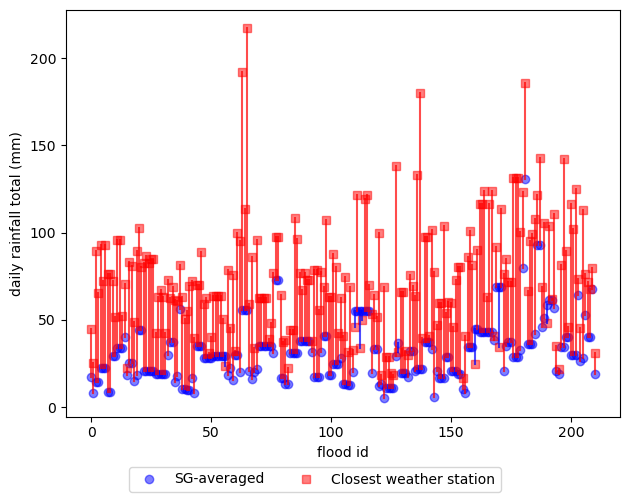

In [56]:
def plot_timeseries_floods(floods_df,save_dir=None):
    flood_id = np.arange(len(floods_df.index),dtype=int)
    mean_pr_sg = floods_df['mean_pr'].values # mean total rainfall across sg
    closest_pr = floods_df['daily rainfall total (mm)'].values # ppt value from the closest weather station to the flood location

    fig, ax = plt.subplots()
    ax.plot(flood_id,mean_pr_sg,'bo',alpha=0.5,label='SG-averaged')
    ax.plot(flood_id,closest_pr,'rs',alpha=0.5,label='Closest weather station')
    ax.plot((flood_id[mean_pr_sg>closest_pr],flood_id[mean_pr_sg>closest_pr]),(mean_pr_sg[mean_pr_sg>closest_pr],closest_pr[mean_pr_sg>closest_pr]),c='blue',alpha=0.7)
    ax.plot((flood_id[mean_pr_sg<closest_pr],flood_id[mean_pr_sg<closest_pr]),(mean_pr_sg[mean_pr_sg<closest_pr],closest_pr[mean_pr_sg<closest_pr]),c='red',alpha=0.7)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels,bbox_to_anchor = (0.5,-0.05), loc = 'lower center',ncol = 2)
    ax.set_xlabel('flood id')
    ax.set_ylabel('daily rainfall total (mm)')
    plt.tight_layout()


    if save_dir is not None and os.path.exists(save_dir):
        # export csv file
        fp_save = os.path.join(save_dir,'Rainfall_sg_versus_station.png')
        plt.savefig(fp_save, bbox_inches = 'tight')

    plt.show()
    
    return 
plot_timeseries_floods(flood_df)
# save_dir=r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\Figures"

<>:16: SyntaxWarning: invalid escape sequence '\ '
<>:16: SyntaxWarning: invalid escape sequence '\ '
C:\Users\hypak\AppData\Local\Temp\ipykernel_30568\3924636078.py:16: SyntaxWarning: invalid escape sequence '\ '
  """


<Axes: >

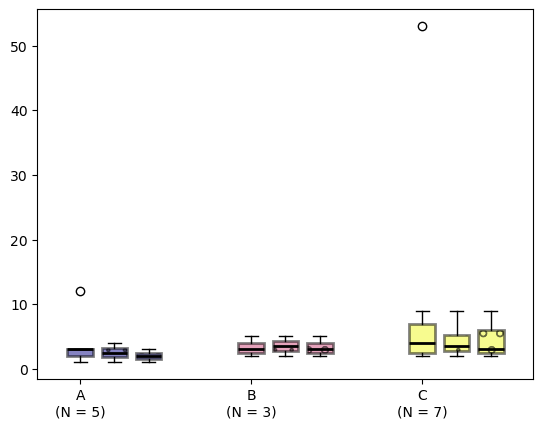

In [ ]:
flood_utils.plot_grouped_boxplot({'A': {'1': [12,3,1,2,3], '2':[1,2,3,4], '3': [1,2,3]},
                    'B': {'1': [5,2,3], '2':[5,2,3,4], '3': [5,2,3]},
                    'C': {'1': [2,4,5,53,9,2,3], '2':[9,2,3,4], '3': [9,2,3]}
        },ax=None)

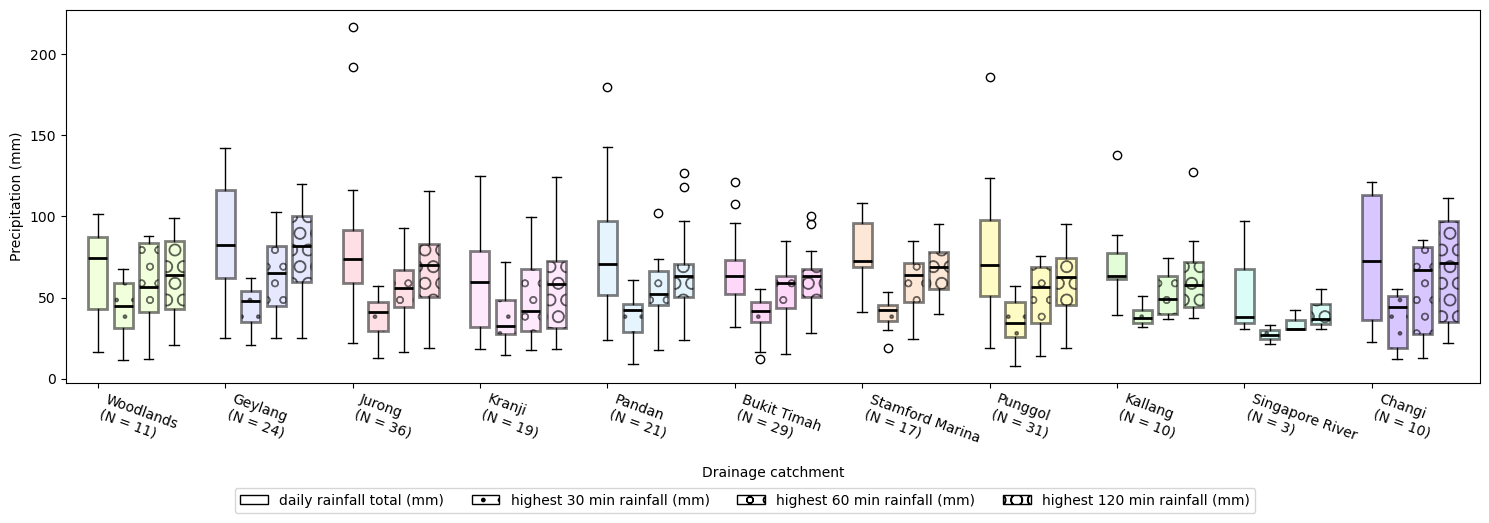

{'Woodlands': {'daily rainfall total (mm)': [45.0,
   22.2,
   89.4,
   84.8,
   84.8,
   99.8,
   40.6,
   74.4,
   101.6,
   16.5,
   45.2],
  'highest 30 min rainfall (mm)': [40.8,
   11.2,
   30.4,
   67.4,
   67.4,
   55.4,
   32.6,
   48.8,
   60.4,
   14.6],
  'highest 60 min rainfall (mm)': [44.0,
   12.2,
   46.4,
   84.4,
   84.4,
   80.4,
   40.0,
   66.4,
   88.0,
   25.8],
  'highest 120 min rainfall (mm)': [44.2,
   20.8,
   53.6,
   84.8,
   84.8,
   99.0,
   40.2,
   74.2,
   98.6,
   42.6]},
 'Geylang': {'daily rainfall total (mm)': [25.0,
   82.6,
   86.4,
   82.6,
   42.4,
   63.2,
   42.4,
   62.6,
   63.4,
   76.8,
   78.8,
   49.6,
   119.2,
   54.0,
   60.0,
   116.2,
   116.2,
   116.2,
   84.8,
   131.4,
   131.4,
   131.4,
   100.2,
   142.0],
  'highest 30 min rainfall (mm)': [21.0,
   46.0,
   48.4,
   46.0,
   34.6,
   53.2,
   34.6,
   47.2,
   48.8,
   51.2,
   53.8,
   25.8,
   28.6,
   24.6,
   28.4,
   55.0,
   55.0,
   55.0,
   43.4,
   61.8,
   61.8,

In [ ]:
# plot_boxplots_floods_by_drainage(flood_df)
save_dir=r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\Figures"
boxplot_data = flood_utils.get_boxplot_data(flood_df)
flood_utils.plot_boxplots_floods_by_drainage(boxplot_data, show_fliers=True, save_dir=r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\Figures")

# Misc

# Plot historical flood events

C:\Users\hypak\AppData\Local\Temp\ipykernel_33652\2270567213.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_pr['High Tide'] = floods_df['High Tide'].values


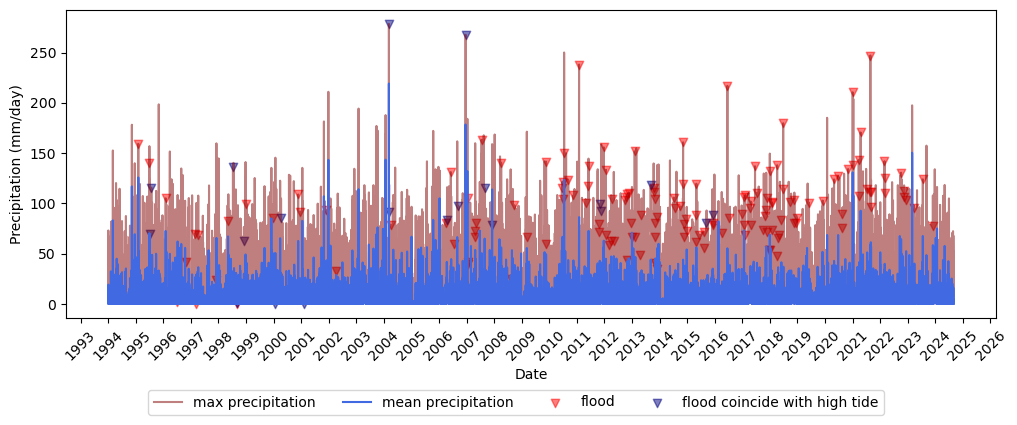

,Date,mean_pr,min_pr,max_pr,High Tide
399,1995-02-04,125.825000,101.0,159.3,False
547,1995-07-02,70.388462,23.3,140.0,False
550,1995-07-05,23.719231,1.6,69.2,True
572,1995-07-27,34.953846,5.7,115.7,True
762,1996-02-02,72.623077,21.3,105.1,False
...,...,...,...,...,...
10542,2022-11-12,28.197917,0.0,112.8,False
10571,2022-12-11,52.506522,17.4,103.0,False
10680,2023-03-30,40.154348,4.2,95.4,False
10792,2023-07-20,67.604762,30.0,124.0,False


In [391]:
def plot_timeseries_pr(df,floods_df,save_dir=None):
    summary = df.groupby(["Date"]).agg(mean_pr=('daily rainfall total (mm)','mean'),
                                                min_pr=('daily rainfall total (mm)','min'),
                                                max_pr=('daily rainfall total (mm)','max')
                                                ).reset_index()
    
    # high_tide_events = floods_df['High Tide'][floods_df['High Tide'] == True].index
    # flood_no_tide_events = floods_df['High Tide'][floods_df['High Tide'] == False].index
    flood_dates = floods_df['Date']
    flood_pr = summary[summary['Date'].isin(flood_dates)]
    flood_pr['High Tide'] = floods_df['High Tide'].values
    flood_hightide = flood_pr[flood_pr['High Tide'] == True]
    flood_notide = flood_pr[flood_pr['High Tide'] == False]
    color_flood = ['red','navy']
    floods = [flood_notide,flood_hightide]
    flood_labels = ['flood','flood coincide with high tide']
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    ax.plot(summary['Date'],summary['max_pr'],color='maroon',alpha=0.5,label="max precipitation")
    ax.plot(summary['Date'],summary['mean_pr'],color='royalblue',label="mean precipitation")
    for f,c,t in zip(floods,color_flood,flood_labels):
        ax.scatter(f['Date'],f['max_pr'],c=c,marker="v",alpha=0.5,label=t)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.set_ylabel('Precipitation (mm/day)')
    ax.set_xlabel('Date')
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=45)
    fig.legend(bbox_to_anchor = (0.5,-0.15), loc = 'lower center',ncol = 4)

    if os.path.exists(save_dir):
        # export csv file
        fp_save = os.path.join(save_dir,'flood_frequency_timeseries.png')
        plt.savefig(fp_save, bbox_inches = 'tight')

    plt.show()
    return flood_pr

plot_timeseries_pr(historical_weather,historical_floods,save_dir=r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\Figures")

Dates where SG-averaged is higher than closest weather stn: 
['1996-07-01T00:00:00.000000000' '1998-05-05T00:00:00.000000000'
 '1999-01-06T00:00:00.000000000' '2006-04-03T00:00:00.000000000'
 '2006-06-10T00:00:00.000000000' '2007-01-19T00:00:00.000000000'
 '2007-01-21T00:00:00.000000000' '2007-04-23T00:00:00.000000000'
 '2008-08-09T00:00:00.000000000' '2008-09-26T00:00:00.000000000'
 '2011-06-09T00:00:00.000000000' '2012-01-20T00:00:00.000000000'
 '2012-04-02T00:00:00.000000000' '2012-05-05T00:00:00.000000000'
 '2012-10-31T00:00:00.000000000' '2013-02-05T00:00:00.000000000'
 '2013-04-17T00:00:00.000000000' '2015-04-28T00:00:00.000000000'
 '2020-08-14T00:00:00.000000000']
Dates where SG-averaged is higher than closest weather stn: 
['2015-04-28T00:00:00.000000000' '2017-06-18T00:00:00.000000000']
Dates where SG-averaged is higher than closest weather stn: 
['2015-04-28T00:00:00.000000000' '2022-11-07T00:00:00.000000000']
Dates where SG-averaged is higher than closest weather stn: 
['201

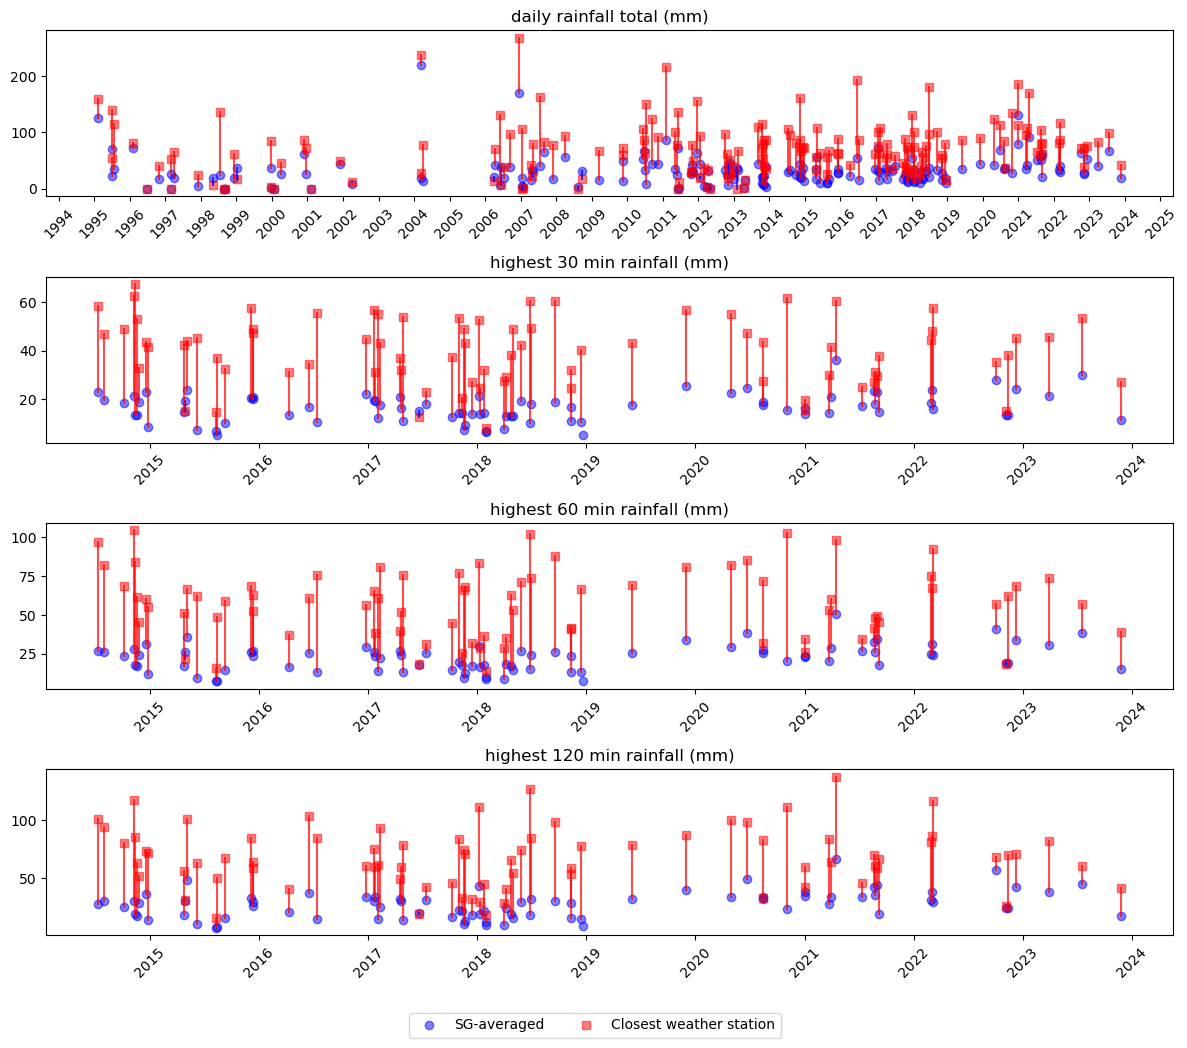

In [392]:
def plot_timeseries_floods(weather_df,floods_df,rainfall_floods,save_dir=None):
    assert len(floods_df.index) == len(rainfall_floods)
    flood_dates = floods_df['Date'].values
    # mean daily precipitation across sg
    mean_pr_sg = weather_df.groupby(['Date']).agg(mean_prdaily=('daily rainfall total (mm)','mean'),
                                                  mean_pr30=('highest 30 min rainfall (mm)','mean'),
                                                  mean_pr60=('highest 60 min rainfall (mm)','mean'),
                                                  mean_pr120=('highest 120 min rainfall (mm)','mean'),
                                                  ).reset_index()
    mean_pr_sg = mean_pr_sg[mean_pr_sg['Date'].isin(flood_dates)]

    fig, axes = plt.subplots(4,1,figsize=(12,10))
    titles = ['daily rainfall total (mm)','highest 30 min rainfall (mm)','highest 60 min rainfall (mm)','highest 120 min rainfall (mm)']
    for i,(ax, title) in enumerate(zip(axes.flatten(),titles)):
        y_sg = mean_pr_sg.iloc[:,i+1].values
        y_stn = np.array([j['summary_stats'].iloc[-1,i] for j in rainfall_floods]) # aggregated across multiple weather stations at times, maybe take the max would be better
        ax.plot(flood_dates,y_sg,'bo',alpha=0.5,label='SG-averaged')
        ax.plot(flood_dates,y_stn,'rs',alpha=0.5,label='Closest weather station') # aggregated across multiple weather stations at times, maybe take the max would be better

        ax.plot((flood_dates[y_sg>y_stn],flood_dates[y_sg>y_stn]),(y_sg[y_sg>y_stn],y_stn[y_sg>y_stn]),c='blue',alpha=0.7)
        print(f'Dates where SG-averaged is higher than closest weather stn: \n{flood_dates[y_sg>y_stn]}')
        ax.plot((flood_dates[y_sg<y_stn],flood_dates[y_sg<y_stn]),(y_sg[y_sg<y_stn],y_stn[y_sg<y_stn]),c='red',alpha=0.7)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
        # ax.set_ylabel('Precipitation (mm/day)')
        # ax.set_xlabel('Date')
        ax.set_title(titles[i])
        for label in ax.get_xticklabels(which='major'):
            label.set(rotation=45)
    # add legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels,bbox_to_anchor = (0.5,-0.05), loc = 'lower center',ncol = 4)
    plt.tight_layout()

    if os.path.exists(save_dir):
        # export csv file
        fp_save = os.path.join(save_dir,'Rainfall_sg_versus_station.png')
        plt.savefig(fp_save, bbox_inches = 'tight')

    plt.show()
    
    return 
plot_timeseries_floods(historical_weather,historical_floods,rainfall_floods,save_dir=r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Projects\Risk Assessment\Figures")


# Plot spatial distribution of floods

### Assign weather stations to drainage catchment

In [7]:
def extract_drainage_catchment(drainage_catchment_fn,weather_stn_dict):
    """ from the flood coordinates, extracts the corresponding drainage catchment from the shp file and add to dict
    Args:
        drainage_catchment_fn (str): filepath to a multipolygon shapefile
        weather_stn_dict (dict): where keys represent datetime, values refer to a list of dict that contains the individual flood attributes
    Returns:
        dict: whether if a polygon contains a point
    """
    drainage_catchment = flood_utils.grid_code_drainage_catchment()
    with gdal.OpenEx(drainage_catchment_fn) as ds:
        lyr = ds.GetLayer(0)
        for stn_name , stn_att in weather_stn_dict.items():
            lat = float(stn_att['latitude'])
            lon = float(stn_att['longitude'])
            point = flood_utils.load_points(lon, lat)
            # initialise with values
            found = False
            nearest_distance = np.inf
            nearest_drainage_catchment = None
            for feature in lyr:
                geom = feature.GetGeometryRef()
                field_value = feature.GetField('gridcode')
                # check if point is within polygon
                if geom.Contains(point):
                    matched_drainage = drainage_catchment[int(field_value)]
                    stn_att['drainage_map'] = matched_drainage
                    found = True # update boolean flag to true if point is within polygon
                # if point is not within the polygon, compute the distance of point to the polygon instead
                else:
                    distance = point.Distance(geom)
                    if distance < nearest_distance:
                        nearest_distance = distance # update nearest distance by iterating through geom
                        nearest_drainage_catchment = drainage_catchment[int(field_value)]
            
            if not found: # if points are not found within polygon, assign drainage catchment as the nearest drainage catchment
                stn_att['drainage_map'] = nearest_drainage_catchment
                    
    return weather_stn_dict


weather_stn_dict1 = extract_drainage_catchment(drainage_catchment_fn=r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_DrainageMap\SG_DrainageCatchment.shp",
                           weather_stn_dict={i['station_name']:i for i in weather_stns_dict.values()})
weather_stn_dict1

c:\Users\hypak\.conda\envs\fiat_conda\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


{'Paya Lebar': {'station_code': 'S06',
  'station_name': 'Paya Lebar',
  'longitude': 103.9037333,
  'latitude': 1.35713333,
  'drainage_map': 'Punggol'},
 'Macritchie Reservoir': {'station_code': 'S07',
  'station_name': 'Macritchie Reservoir',
  'longitude': 103.8339,
  'latitude': 1.3418,
  'drainage_map': 'Bukit Timah'},
 'Lower Peirce Reservoir': {'station_code': 'S08',
  'station_name': 'Lower Peirce Reservoir',
  'longitude': 103.8270667,
  'latitude': 1.37003333,
  'drainage_map': 'Kallang'},
 'Jurong (North)': {'station_code': 'S101',
  'station_name': 'Jurong (North)',
  'longitude': 103.7134,
  'latitude': 1.35053333,
  'drainage_map': 'Jurong'},
 'Semakau Island': {'station_code': 'S102',
  'station_name': 'Semakau Island',
  'longitude': 103.7657167,
  'latitude': 1.19016667,
  'drainage_map': 'Pandan'},
 'Admiralty': {'station_code': 'S104',
  'station_name': 'Admiralty',
  'longitude': 103.7853833,
  'latitude': 1.44386667,
  'drainage_map': 'Woodlands'},
 'Admiralty Wes

## Export weather data

In [ ]:
save_dir = os.path.join(os.getcwd(),"Exported_Data")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
historical_weather['drainage_catchment'] = [weather_stn_dict1[stn]['drainage_map'] for stn in historical_weather['station'].to_list()]
historical_weather.to_csv(os.path.join(save_dir,'historical_weather.csv'),index=False)

'c:\\Users\\hypak\\OneDrive - Singapore Management University\\Documents\\Projects\\Risk Assessment\\V3 analysis\\Exported_Data'